# Explore here

Step 1: Load and Explore Data


In [5]:
# Your code here
import pandas as pd
import pickle
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
# Load data
url = "https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv"
df = pd.read_csv(url)

# Show first 5 rows
df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


Step 2: Preprocess Text Data


🔍 Package Name Analysis:
Unique apps: 23
Top 5 apps by review count:


/tmp/ipykernel_16922/663073060.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_apps.values, y=top_apps.index, palette='viridis')


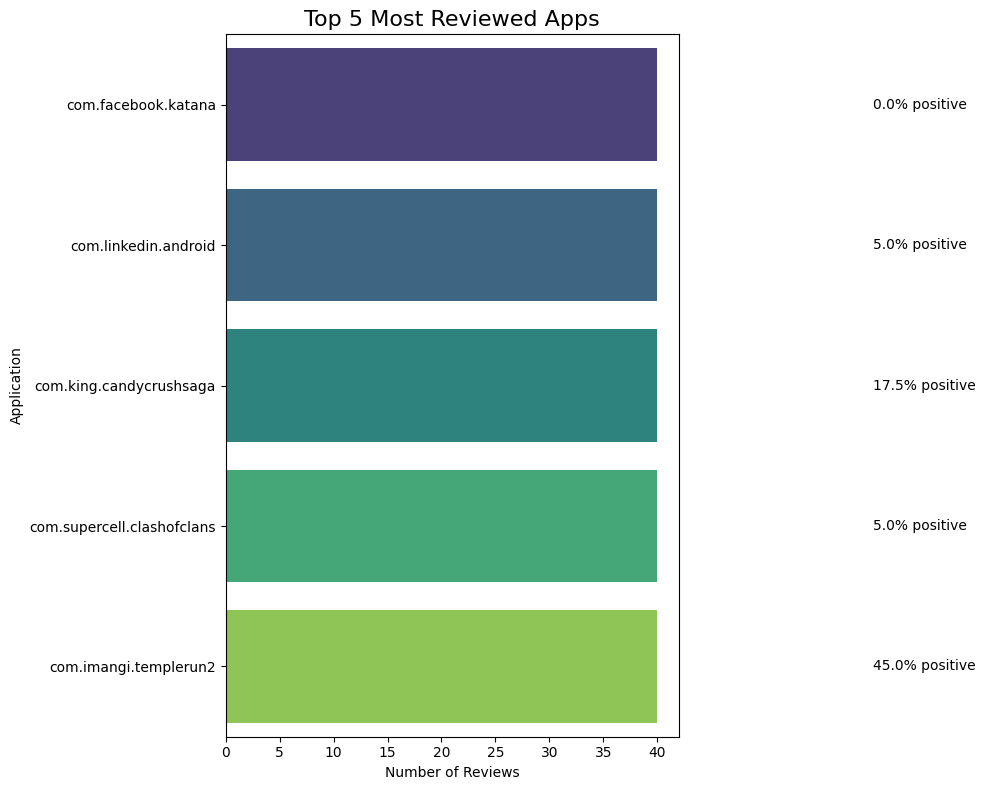

✅ Dropped 'package_name' column as instructed


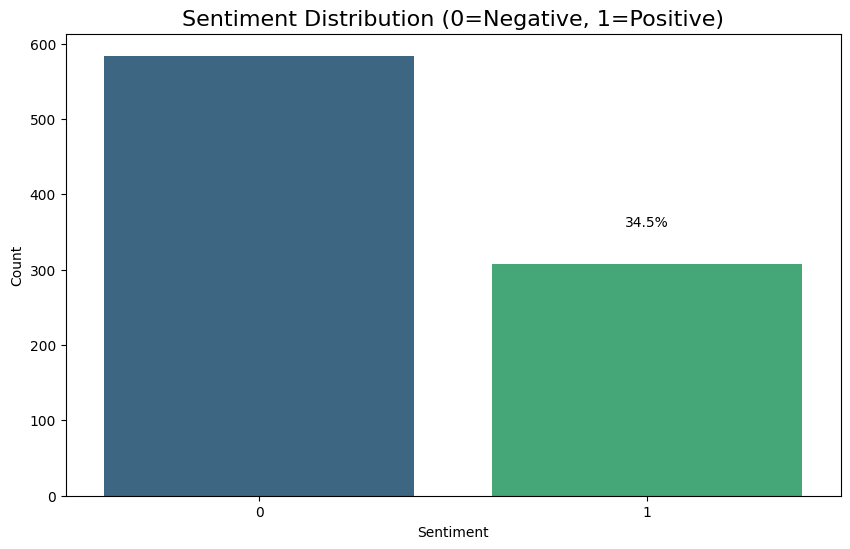

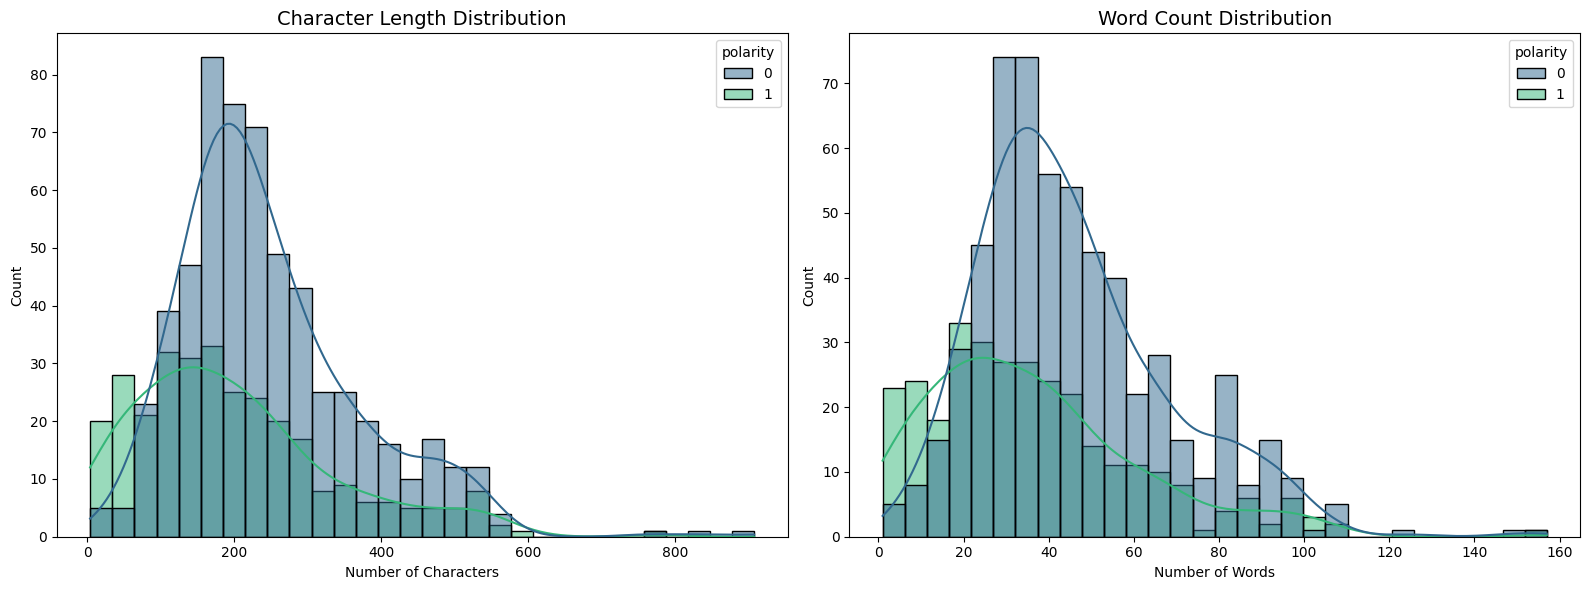

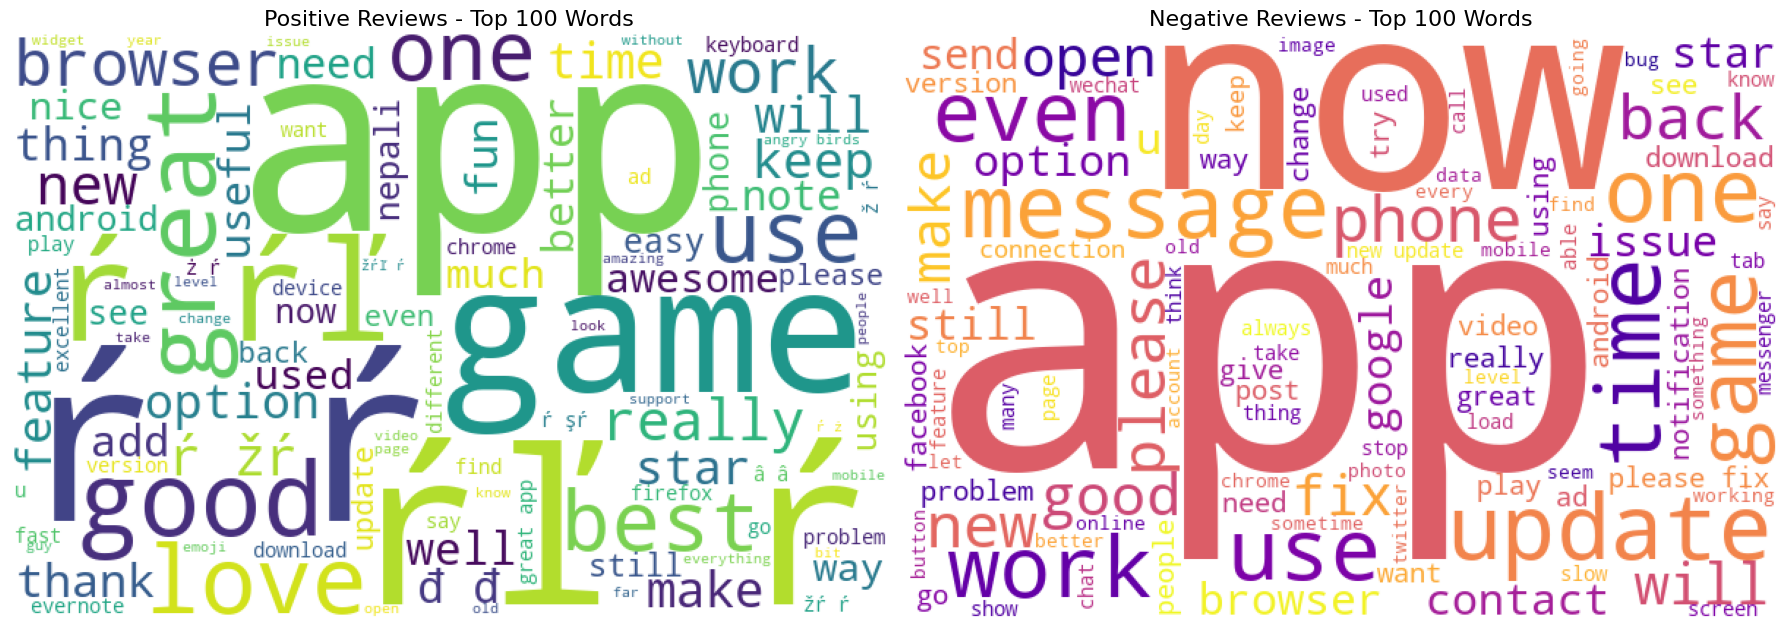

/tmp/ipykernel_16922/663073060.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='polarity', y='review_length', data=df, palette='viridis')


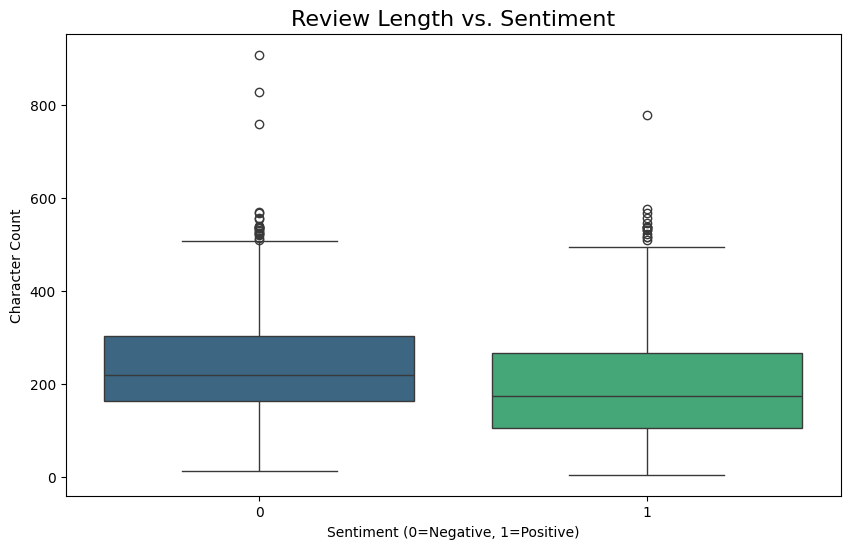


📊 Correlation between sentiment and review length: -0.1690 (near zero = no relationship)
✅ Temporary columns dropped
✅ Data split into training and test sets


In [6]:
df['review'] = df['review'].str.strip().str.lower()

# --- 1. Package Analysis ---
print("\n🔍 Package Name Analysis:")
print(f"Unique apps: {df['package_name'].nunique()}")
print(f"Top 5 apps by review count:")

# Top apps analysis
plt.figure(figsize=(12, 8))
top_apps = df['package_name'].value_counts().nlargest(5)
ax = sns.barplot(x=top_apps.values, y=top_apps.index, palette='viridis')
plt.title('Top 5 Most Reviewed Apps', fontsize=16)
plt.xlabel('Number of Reviews')
plt.ylabel('Application')

# Add sentiment distribution
for i, app in enumerate(top_apps.index):
    app_reviews = df[df['package_name']==app]
    pos_percent = 100 * app_reviews['polarity'].mean()
    ax.text(top_apps.values[i] + 20, i, 
            f'{pos_percent:.1f}% positive', 
            va='center', fontsize=10)
plt.tight_layout()
plt.show()

# --- Remove package column ---
df = df.drop(columns=['package_name'])
print("✅ Dropped 'package_name' column as instructed")

# --- 2. Sentiment Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='polarity', data=df, palette='viridis', hue='polarity', legend=False)
plt.title('Sentiment Distribution (0=Negative, 1=Positive)', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 50
    ax.annotate(percentage, (x, y), ha='center', fontsize=10)
plt.show()

# --- 3. Review Length Analysis ---
df['review_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df, x='review_length', hue='polarity', bins=30, 
             kde=True, palette='viridis', ax=axes[0])
axes[0].set_title('Character Length Distribution', fontsize=14)
axes[0].set_xlabel('Number of Characters')

sns.histplot(df, x='word_count', hue='polarity', bins=30, 
             kde=True, palette='viridis', ax=axes[1])
axes[1].set_title('Word Count Distribution', fontsize=14)
axes[1].set_xlabel('Number of Words')
plt.tight_layout()
plt.show()

# --- 4. Word Clouds ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
positive_text = " ".join(df[df['polarity']==1]['review'])
negative_text = " ".join(df[df['polarity']==0]['review'])

positive_wc = WordCloud(width=600, height=400, background_color='white', 
                        colormap='viridis', max_words=100).generate(positive_text)
axes[0].imshow(positive_wc)
axes[0].set_title('Positive Reviews - Top 100 Words', fontsize=16)
axes[0].axis('off')

negative_wc = WordCloud(width=600, height=400, background_color='white', 
                        colormap='plasma', max_words=100).generate(negative_text)
axes[1].imshow(negative_wc)
axes[1].set_title('Negative Reviews - Top 100 Words', fontsize=16)
axes[1].axis('off')
plt.tight_layout()
plt.show()

# --- 5. Sentiment vs Length ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='polarity', y='review_length', data=df, palette='viridis')
plt.title('Review Length vs. Sentiment', fontsize=16)
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Character Count')
plt.show()

# Correlation calculation
corr = df[['polarity', 'review_length']].corr().iloc[0,1]
print(f"\n📊 Correlation between sentiment and review length: {corr:.4f} (near zero = no relationship)")

# --- 6. Cleanup before modeling ---
df = df.drop(columns=['review_length', 'word_count'])
print("✅ Temporary columns dropped")

X = df['review']
y = df['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Data split into training and test sets")

Step 3: Convert Text to Numbers

In [7]:
# Create word-count matrix (ignore English stopwords)
print("🔠 Converting text to numbers...")
vectorizer = CountVectorizer(stop_words='english')

# Fit on training data, transform both sets
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())} words")
print(f"Training matrix shape: {X_train_vec.shape}")
print(f"Test matrix shape: {X_test_vec.shape}")

🔠 Converting text to numbers...
Vocabulary size: 3310 words
Training matrix shape: (712, 3310)
Test matrix shape: (179, 3310)


Step 4: Build & Compare Naive Bayes Models


🔬 Model Performance Insights:


/tmp/ipykernel_16922/2075819298.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models_df.index, y=models_df['Accuracy'], palette='viridis')


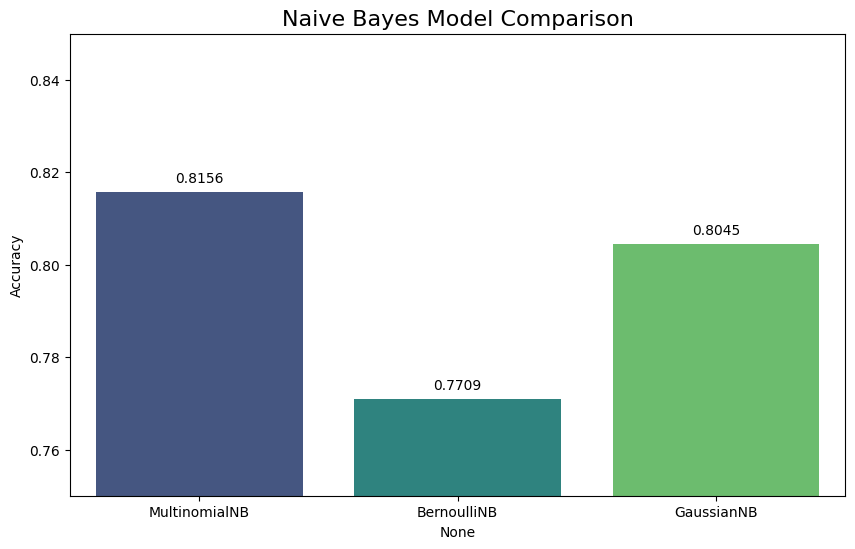

Why MultinomialNB won:
- Our features are WORD COUNTS (discrete numbers)
- MultinomialNB handles discrete frequency data best
- BernoulliNB assumes binary features (presence/absence)
- GaussianNB assumes continuous normal distributions


/tmp/ipykernel_16922/2075819298.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Word', data=top_words, palette='viridis')


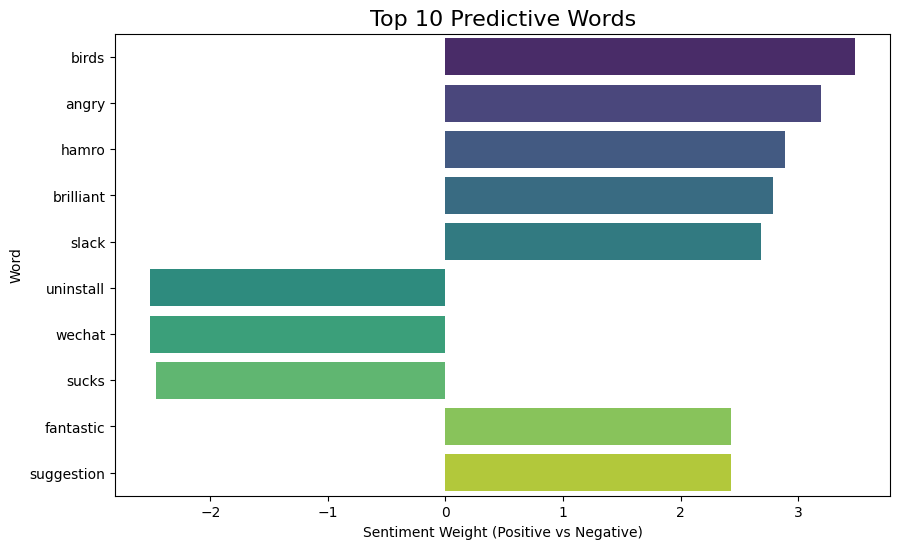

💡 Interpretation:
Positive weights → Strongly associated with POSITIVE reviews
Negative weights → Strongly associated with NEGATIVE reviews


In [8]:
# Initialize models
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB": GaussianNB()
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Show results
pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
# --- Model Performance Analysis ---
print("\n🔬 Model Performance Insights:")

# 1. Create comparison plot
models_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=models_df.index, y=models_df['Accuracy'], palette='viridis')
plt.title('Naive Bayes Model Comparison', fontsize=16)
plt.ylabel('Accuracy')
plt.ylim(0.75, 0.85)  # Focus on relevant range

# Add accuracy labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.show()

# 2. Explain why MultinomialNB performed best
print("Why MultinomialNB won:")
print("- Our features are WORD COUNTS (discrete numbers)")
print("- MultinomialNB handles discrete frequency data best")
print("- BernoulliNB assumes binary features (presence/absence)")
print("- GaussianNB assumes continuous normal distributions")

# 3. Show top predictive words
feature_names = vectorizer.get_feature_names_out()
coefs = models["MultinomialNB"].feature_log_prob_[1] - models["MultinomialNB"].feature_log_prob_[0]
top_words = pd.DataFrame({
    'Word': feature_names,
    'Weight': coefs
}).sort_values('Weight', key=abs, ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Word', data=top_words, palette='viridis')
plt.title('Top 10 Predictive Words', fontsize=16)
plt.xlabel('Sentiment Weight (Positive vs Negative)')
plt.show()

print("💡 Interpretation:")
print("Positive weights → Strongly associated with POSITIVE reviews")
print("Negative weights → Strongly associated with NEGATIVE reviews")

Step 5: Optimize the Best Model


In [9]:
# Tune MultinomialNB (best performer)
alphas = [0.1, 0.5, 1.0, 2.0]  # Smoothing parameters

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train_vec, y_train)
    acc = model.score(X_test_vec, y_test)
    print(f"Alpha {alpha}: Accuracy = {acc:.4f}")

Alpha 0.1: Accuracy = 0.8324
Alpha 0.5: Accuracy = 0.8268
Alpha 1.0: Accuracy = 0.8156
Alpha 2.0: Accuracy = 0.8324


Step 6: Compare with Random Forest


In [10]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_vec, y_train)
rf_acc = rf.score(X_test_vec, y_test)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"Best NB Accuracy: {max(results.values()):.4f}")

Random Forest Accuracy: 0.7821
Best NB Accuracy: 0.8156


Step 7: Save the Model


In [11]:
# Save best model
best_model = MultinomialNB(alpha=0.5)
best_model.fit(X_train_vec, y_train)
pickle.dump(best_model, open('naive_bayes_model.pkl', 'wb'))

# Save vectorizer too (for new text preprocessing)
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
